In [107]:
###############################set the environment#####################################################################
import pandas.io.sql as sql
from lxml.html import parse
from urllib.request import urlopen
import pandas as pd
import urllib 
import numpy as np
from matplotlib.pyplot import plot,savefig 
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import statsmodels.api as sm
import scipy.stats as stats 
import sympy as sy
import scipy.optimize as scopt 
from sympy.interactive import printing
printing.init_printing(use_latex=True)

In [108]:
####################################get_sina_stock###################################################################

def get_sina_stock(stockid,start,end,isstock=True,fuquan=True):    
    def _unpack(row, kind='td'):
        elts = row.findall('.//%s' % kind)
        return [val.text_content().strip() for val in elts]     
    def parse_options_data(table,isstock,fuquan):
        rows = table.findall('.//tr')
        data = [_unpack(r) for r in rows[2:]]
        if isstock & fuquan:
            colnames = ['date','open','high','close','low','vol','amount','ratio'] 
        else:
            colnames = ['date','open','high','close','low','vol','amount']
        data= pd.DataFrame(data,columns=colnames)
        data.index=pd.to_datetime(data["date"])
        data=data.drop("date",axis=1)
        data=data.ix[range(len(data)-1,-1,-1)]
        return  data
    data=pd.DataFrame()
    daterange=pd.date_range(start,end,freq="Q")
    daterange=daterange.insert(len(daterange),daterange[-1]+1)
    for cq in daterange: 
        if isstock:
            if fuquan:
                url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_FuQuanMarketHistory/stockid/'+str(stockid)+'.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)
            else:
                url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_MarketHistory/stockid/'+str(stockid)+'.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)            
        else:            
            url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_MarketHistory/stockid/'+str(stockid)+'/type/S.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)
        try:
            parsed = parse(urlopen(url))
        except:
            print ("download failed for year=" +str(cq.year)+',  jidu='+str(cq.month/3))
            continue
        doc = parsed.getroot()
        tables=doc.findall('.//table')     
        da= tables[-1] # last table 19 for fuquan data and 4 for index
        datatem = parse_options_data(da,isstock,fuquan)
        data=pd.concat([data,datatem])
    return pd.DataFrame(data[start:end],dtype=float)    

In [109]:
####################################   get data ###################################################################
start_date="2012-1-1"
end_date="2014-12-31"
data1=get_sina_stock("600352",start=start_date,end=end_date).close
data1.name='600352'
data2=get_sina_stock("600109",start=start_date,end=end_date).close
data2.name='600109'
data3=get_sina_stock("601939",start=start_date,end=end_date).close
data3.name='601939'
data_all=pd.concat([data1,data2,data3],axis=1)
data_all = data_all.dropna()
return_monthly=data.resample('M').last().pct_change().dropna()
Mu=return_monthly.mean().reshape((3,1))
Sigma=return_monthly.cov()
print(Mu)

[[ 0.0412535 ]
 [ 0.05177002]
 [ 0.01842906]]


In [110]:
w1=sy.symbols('w1',positive = True, real = True)
w2=sy.symbols('w2',positive = True, real = True)
mu1=0.0412535
mu2=0.05177002
mu3=0.01842906
ExpRet=sy.simplify(mu1*w1+mu2*w2+mu3*(1-w1-w2))
#ExpRet of portfolio =
ExpRet

In [111]:
#################################### Calculate the key parameter #################################### 
Sigma=np.matrix(Sigma)
N=len(Mu)
Mu=np.matrix(Mu.reshape(N,1))
onesv=np.matrix(np.ones((N,1)))
SI=Sigma.I
A=Mu.T*SI*onesv; A=A[0,0]
B=Mu.T*SI*Mu; B=B[0,0]
C=onesv.T*SI*onesv; C=C[0,0]
D=B*C-A**2
g=SI*onesv*B/D-SI*Mu*A/D
h=SI*Mu*C/D-SI*onesv*A/D

In [112]:
######################################### mumin & mumax ########################################################## 
mumin=np.min(Mu)
mumax=np.max(Mu)

In [113]:
meanv=np.linspace(mumin,mumax,500)
wv=list(map(lambda x: g+x*h,meanv))
sigmav=list(map(lambda x: np.sqrt(x.T*Sigma*x)[0,0],wv))
mu_min=-g.T*Sigma*h/(h.T*Sigma*h)
sigma_min=np.sqrt(g.T*Sigma*g-(g.T*Sigma*h)**2/(h.T*Sigma*h))

In [114]:
muf=round(1/12*0.03,6)
wt=SI*(Mu-muf)
wt=wt/(onesv.T*wt)
mut=wt.T*Mu
sigmat=np.sqrt(wt.T*Sigma*wt)

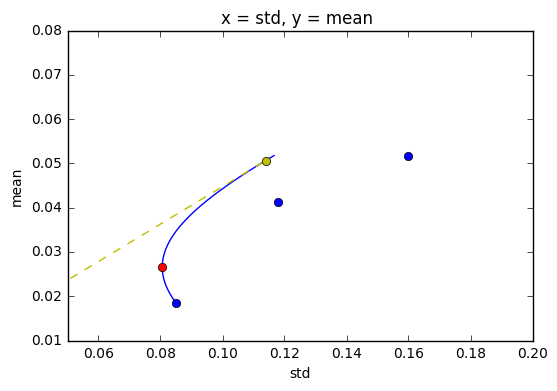

In [115]:
######################################### plot picture ########################################################## 
%matplotlib inline

Sig=return_monthly.std()
plt.plot(sigmav,meanv)
plt.plot(Sig,Mu,"bo")
plt.plot(sigma_min,mu_min,"ro")
plt.plot([0,sigmat.item(0)],[muf,mut.item(0)],"yo--")

plt.xlim([0.05,0.20]) 
plt.ylim([0.01,0.08])
plt.xlabel('std')
plt.ylabel('mean')
plt.title('x = std, y = mean ')

In [116]:
################################  calc_portfolio_std & objfunvar  ################################################## 
def calc_portfolio_std(returns=None,sigma=None, weights=None):
    if weights is None: 
        weights = np.ones(returns.columns.size) / \
        returns.columns.size
    if returns is not None:
        sigma = returns.cov()
    ## the the same result as the  matrix dot
    var = weights.dot(sigma).dot(weights)
    return np.sqrt(var)

def objfunvar(W, R, target_ret):
    cov=np.cov(R.T) 
    port_var = np.dot(np.dot(W,cov),W.T) 
    return np.sqrt(port_var)

In [117]:
#用函数计算允许卖空和禁止卖空条件下的有效前沿
######################################### sellshort=True,sellshort=False #########################################################
def calc_efficient_frontier(returns,sellshort=True):
    result_means = []
    result_stds = []
    result_weights = []
    
    means = returns.mean()
    min_mean, max_mean = means.min(), means.max()
    
    nstocks = returns.columns.size
    if sellshort:
        bounds=None
    else:
        bounds = [(0,1) for i in np.arange(nstocks)]
    for r in np.linspace(min_mean, max_mean, 500):
        weights = np.ones(nstocks)/nstocks        
        constraints = ({'type': 'eq', 
                        'fun': lambda W: np.sum(W) - 1},
                      {'type': 'eq', 
                        'fun': lambda W: np.sum(W*means) -r})
        results = scopt.minimize(objfunvar, weights, (returns, r), 
                                 method='SLSQP', 
                                 constraints = constraints,
                                 bounds = bounds)
        if not results.success: # handle error
            raise Exception(results.message)
        result_means.append(np.round(r,6)) # 6 decimal places
        #std_=np.round(np.std(np.sum(returns*results.x,axis=1)),6)
        std_=objfunvar(results.x,returns,r)
        result_stds.append(std_)        
        result_weights.append(np.round(results.x, 6))
    return {'Means': result_means, 
            'Stds': result_stds, 
            'Weights': result_weights}

In [118]:
x=calc_efficient_frontier(return_monthly)
x1=calc_efficient_frontier(return_monthly,sellshort=False)

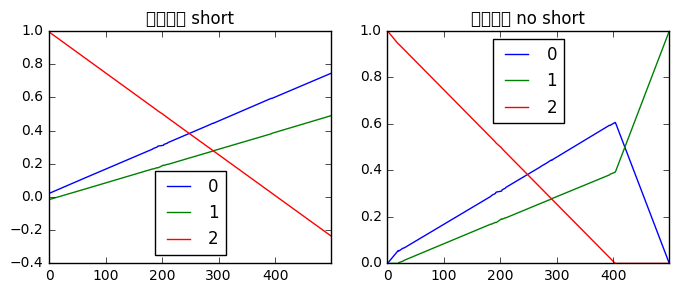

In [119]:
#画出允许卖空和禁止卖空条件下的资产权重变化

plt.figure(figsize=(8, 3))
ax1=plt.subplot(121)
pd.DataFrame(x['Weights']).plot(ax=ax1,title="可以卖空 short")
ax2=plt.subplot(122)
pd.DataFrame(x1['Weights']).plot(ax=ax2,title="禁止卖空 no short")

In [120]:
def negative_sharpe_ratio( weights,means,sig,risk_free_rate = 0.015):
    # get the portfolio variance
    std = calc_portfolio_std(sigma=sig, weights=weights)  
    # and return the sharpe ratio
    return -((means.dot(weights) - risk_free_rate)/(std))

In [121]:
def optimize_portfolio(returns, risk_free_rate,sellshort=True):
    """ 
    Performs the optimization
    """
    means=returns.mean()
    sig=returns.cov()
    if sellshort:
        bounds=None
    else:
        bounds = [(0,1) for i in np.arange(returns.columns.size)]
        
    weights = np.ones(returns.columns.size, 
                 dtype=float) * 1.0 / returns.columns.size
    # minimize the negative sharpe value
    
    
    constraints = ({'type': 'eq', 
                        'fun': lambda W: np.sum(W) - 1})
    results = scopt.minimize(negative_sharpe_ratio, weights, (means,sig, risk_free_rate), 
                                 method='SLSQP', 
                                 constraints = constraints,
                                 bounds = bounds)
    if not results.success: # handle error
        raise Exception(results.message)
    mean_sharpe=results.x.dot(means)    
    std_sharpe=calc_portfolio_std(sigma=sig,weights=results.x)
    return {'Means': mean_sharpe, 
            'Stds': std_sharpe, 
            'Weights': results.x}

In [122]:
T=optimize_portfolio(return_monthly,muf,sellshort=False)
T

{'Means': 0.045494326347371453,
 'Stds': 0.1025105205934979,
 'Weights': array([  5.96746233e-01,   4.03253767e-01,   2.75387352e-17])}

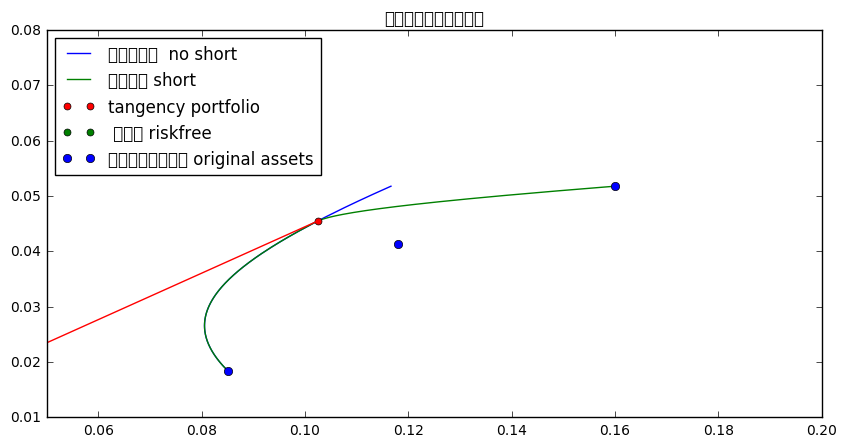

In [123]:
######################################### plot picture ########################################################## 
plt.figure(figsize=(10,5))
plt.plot(x["Stds"],x["Means"],label="不可以卖空  no short")
plt.plot(x1["Stds"],x1["Means"],label="可以卖空 short")
plt.plot(T["Stds"],T["Means"],"ro",markersize=5,label="tangency portfolio")
plt.plot(0,muf,"go",markersize=5,label=" 无风险 riskfree")
plt.plot([0,T["Stds"]],[muf,T["Means"]])
plt.plot(Sig,Mu,"bo",label="原始资产（三个） original assets")
plt.xlim(0.05,0.20)
plt.ylim(0.01,0.08)
plt.legend(loc='upper left')
plt.title('卖空条件下的资产优化')

In [124]:
#################################### portfolio 1  #################################################################
weights_min=x1['Weights'][x1['Stds'].index(min(x1['Stds']))]


####################################   get data ###################################################################
start_date_2 = "2014-12-31"
end_date_2 = "2016-10-31"
data1_2=get_sina_stock("600352",start=start_date_2,end=end_date_2).close
data1_2.name='600352'
data2_2=get_sina_stock("600109",start=start_date_2,end=end_date_2).close
data2_2.name='600109'
data3_2=get_sina_stock("601939",start=start_date_2,end=end_date_2).close
data3_2.name='601939'
data_2=pd.concat([data1_2,data2_2,data3_2],axis=1)
return_monthly_2=data_2.resample('M').last().pct_change().dropna()
return_monthly_2.describe()

,600352,600109,601939
count,22.000000,22.000000,22.000000
mean,0.009788,-0.003851,-0.003179
std,0.156517,0.163513,0.082636
min,-0.331617,-0.316803,-0.167858
25%,-0.112042,-0.079272,-0.051839
50%,0.012751,0.010654,0.008706
75%,0.104280,0.048859,0.056645
max,0.288186,0.269127,0.122923


In [125]:
#组合2的权重
x1_2=calc_efficient_frontier(return_monthly_2,sellshort=False)
weights_min_2=x1_2['Weights'][x1_2['Stds'].index(min(x1_2['Stds']))]
weights_min_2

array([ 0.097829,  0.      ,  0.902171])

In [126]:
########################################test 2 portfolios##########################################################
a=return_monthly_2*weights_min
b=return_monthly_2*weights_min_2
return_test=pd.DataFrame([[sum(a.ix[x]) for x in range(0,22)],[sum(b.ix[x]) for x in range(0,22)]],index=['portfolio1','portfolio2']).T
return_test.index=return_monthly_2.index
return_test.describe()

,portfolio1,portfolio2
count,22.000000,22.000000
mean,-0.000653,-0.001910
std,0.088140,0.081382
min,-0.215409,-0.183878
25%,-0.027169,-0.045310
50%,0.014490,0.002848
75%,0.056419,0.067397
max,0.135347,0.113368


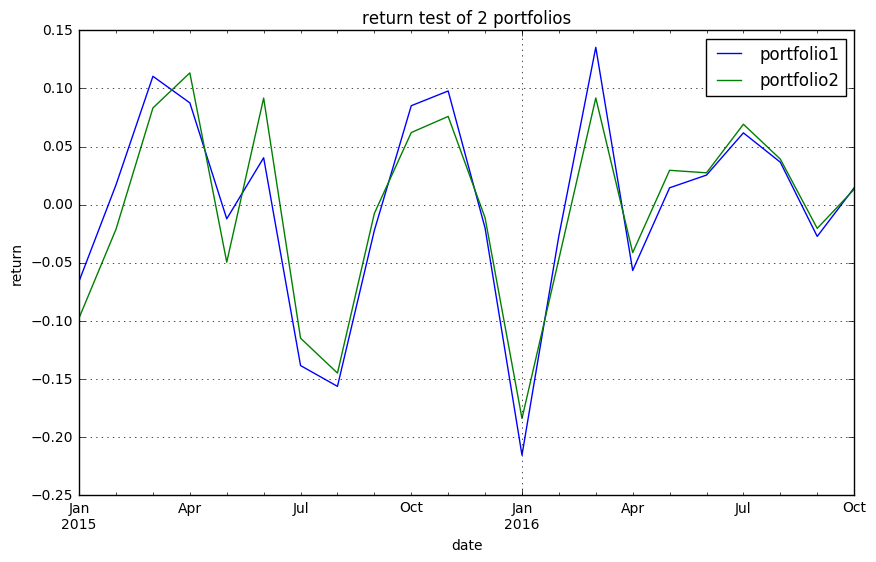

In [106]:
###两个组合在回测时表现类似
return_test.plot(figsize=(10,6),title='return test of 2 portfolios',grid=True)
plt.xlabel('date')
plt.ylabel('return')